In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import networkx as nx
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

1. Cargar el dataset con los datos para cada sujeto y los nombres y coordenadas de las regiones cerebrales a las que se les registró la actividad

In [3]:
RegionsNames = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]
RegionsNames.head()

,1,2,3,4,5,6,7
0,Precentral_L,2001,Central,L,-39,-6,51
1,Precentral_R,2002,Central,R,41,-8,52
2,Frontal_Sup_L,2101,Frontal,L,-18,35,42
3,Frontal_Sup_R,2102,Frontal,R,22,31,44
4,Frontal_Sup_Orb_L,2111,Frontal,L,-17,47,-13


In [4]:
files = os.listdir('DataSujetos/')
sujetos = pd.DataFrame(files)
sujetos['estado'] = sujetos[0].apply(lambda x:x.split('_')[0])
sujetos['sujeto'] = sujetos[0].apply(lambda x:x.split('_')[1].split('.')[0])
sujetos['sujeto'] = sujetos['sujeto'].str.replace(repl='',pat='suj').astype('object')
sujetos.rename(columns={0:'path'},inplace=True)
sujetos.set_index('path',inplace=True)
sujetos.head()

,estado,sujeto
path,,
N1_suj1.csv,N1,1
N1_suj10.csv,N1,10
N1_suj11.csv,N1,11
N1_suj12.csv,N1,12
N1_suj13.csv,N1,13


2. Reportar cuántos sujetos y cuántos estados de sueño se observan en el conjunto de
datos.

In [5]:
print(sujetos.estado.value_counts().reset_index(drop=False).to_latex(index=False))

\begin{tabular}{lr}
\toprule
estado & count \\
\midrule
N1 & 18 \\
N2 & 18 \\
N3 & 18 \\
W & 18 \\
\bottomrule
\end{tabular}



3. Graficar la matriz de correlaciones entre regiones (es decir, la "matriz de adyacencia
pesada") para el sujeto 2 de la condición despierto ("Wake")

In [6]:
suj2_w = sujetos[(sujetos['sujeto']=='2')&(sujetos['estado']=='W')].index[0]
suj2_w = pd.read_csv('DataSujetos/'+suj2_w,header=None)

matAdyacPesada = suj2_w.values
n = matAdyacPesada.shape[0]
matAdyacPesada -= np.diag(np.ones(n))

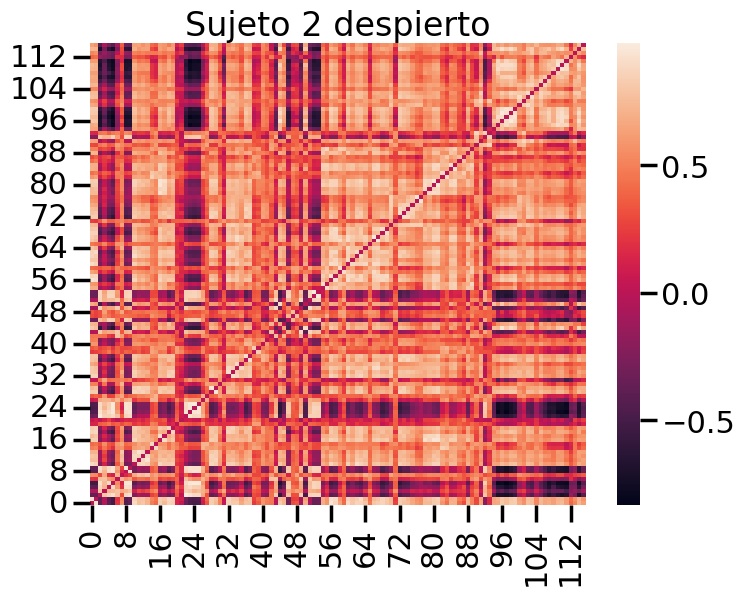

In [7]:
sns.heatmap(matAdyacPesada)
plt.xlim(0,n)
plt.ylim(0,n)
plt.title('Sujeto 2 despierto');

4. Transformar dicha matriz de adyacencia pesada a una matriz de adyancia binaria Ai,j
que represente una una densidad de enlaces δ=0.08. ¿Cuál es el valor de umbral de
correlación entre pares de regiones que tuvo que utilizar?

In [8]:
def density_to_th(W, d):
    n=W.shape[0]
    tril_idx = np.tril_indices(n,-1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)*d)]

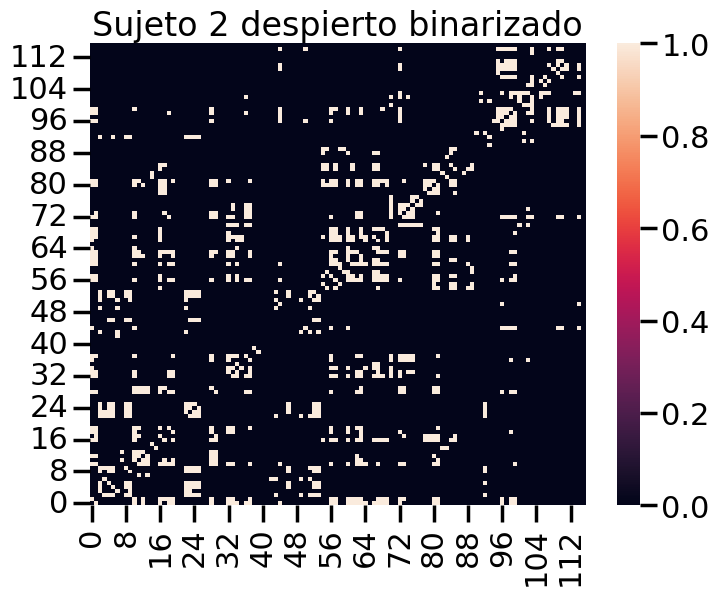

In [9]:
densidad=0.08 # comparemos ambos estados con una densidad de enlaces de 10%

thWake=density_to_th(matAdyacPesada, densidad)
matAdyacNoPesada = matAdyacPesada>=thWake

sns.heatmap(matAdyacNoPesada)
plt.xlim(0,n)
plt.ylim(0,n)
plt.title('Sujeto 2 despierto binarizado');

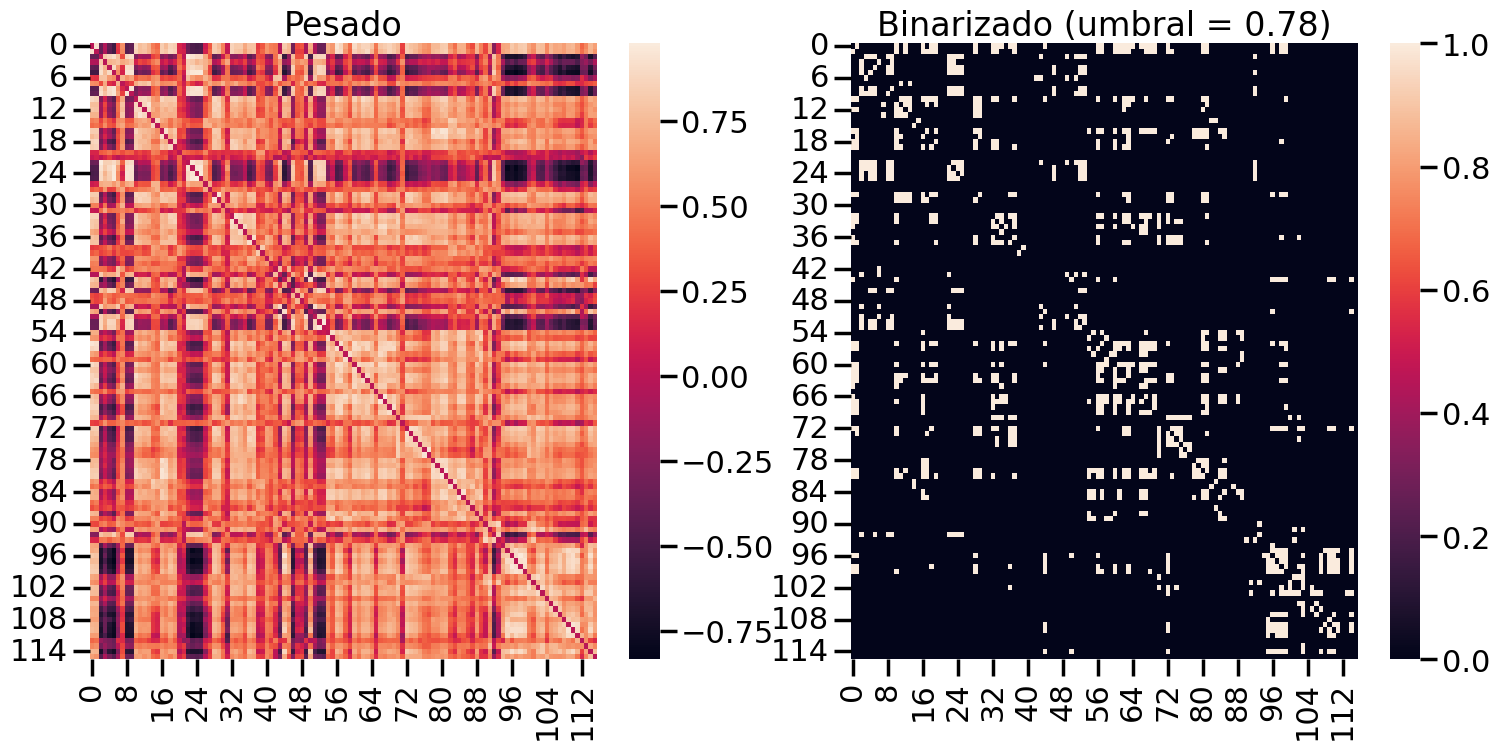

In [10]:
densidad=0.08 # comparemos ambos estados con una densidad de enlaces de 10%

thWake=density_to_th(matAdyacPesada, densidad)

# graficar los dos gráficos de arriba en uno solo
fig, axs = plt.subplots(1,2,figsize=(18,8))
sns.heatmap(matAdyacPesada,ax=axs[0])
axs[0].set_title('Pesado')
sns.heatmap(matAdyacNoPesada,ax=axs[1])
axs[1].set_title(f'Binarizado (umbral = {thWake:.2f})')
# plt.suptitle('Sujeto 2 despierto (W)');
plt.savefig('proyecto_latex/imagenes/1_Sujeto2W.png')


5. Utilizando Ai,j , obtener el grafo resultante G

In [11]:
G = nx.from_numpy_array(matAdyacNoPesada)

6. ¿Es G un grafo conectado? ¿Se puede calcular la distancia media entre pares de nodos
d del grafo G? ¿Si no se puede, qué medida equivalente calcularías?

In [12]:
#detect if graph G is connected
print(nx.is_connected(G))

#calcular la distancia media entre pares de nodos d del grafo G
# distancia_media = nx.average_shortest_path_length(G)

False


In [12]:
max(nx.connected_components(G),key=len)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 16,
 17,
 18,
 19,
 22,
 23,
 24,
 25,
 28,
 29,
 32,
 33,
 34,
 35,
 36,
 37,
 42,
 43,
 44,
 46,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 66,
 67,
 68,
 69,
 70,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 84,
 85,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 113,
 114}

In [13]:
G.subgraph(max(nx.connected_components(G),key=len))

In [14]:
# Encuentra el componente gigante
G_giant = max(nx.connected_components(G), key=len)

# Crea un subgrafo con solo los nodos en el componente gigante
G_giant = G.subgraph(G_giant)

# Calcula todas las distancias entre pares de nodos
distances = dict(nx.all_pairs_shortest_path_length(G_giant))

# Calcula la media de las distancias
mean_distance = np.mean([dist for source, target_dict in distances.items() for dist in target_dict.values()])

print(f"La distancia media del componente gigante es {mean_distance}")

La distancia media del componente gigante es 3.8508979206049148


In [17]:
#calcular eficiencia global del grafo G
eficiencia_global = nx.global_efficiency(G)
print("La eficiencia global del grafo es: ", round(eficiencia_global,4))


La eficiencia global del grafo es:  0.2446


In [15]:
G_largest_cc = max(nx.connected_components(G), key=len)
size_largest_cc = len(G_largest_cc)

In [16]:
num_connected_components = nx.number_connected_components(G)

7- Calcular d para cada componente conectado de G. Calcular la eﬁciencia global ef f del grafo G.

In [17]:
# Calcula los componentes conectados
connected_components = nx.connected_components(G)

# Para cada componente conectado, calcula la distancia media
for component in connected_components:
    # Crea un subgrafo con solo los nodos en este componente
    subgraph = G.subgraph(component)
    
    # Calcula todas las distancias entre pares de nodos
    distances = nx.all_pairs_shortest_path_length(subgraph)
    
    # Calcula la media de las distancias
    mean_distance = np.mean([dist for source, target_dict in distances for dist in target_dict.values()])
    
    print(f"La distancia media para este componente es {mean_distance}")

La distancia media para este componente es 3.8508979206049148
La distancia media para este componente es 1.28
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.5
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0
La distancia media para este componente es 0.0


In [18]:

#calcular la eficiencia global del grafo G
eficiencia = nx.global_efficiency(G)

print("La eficiencia global del grafo G es:", round(eficiencia,4))

La eficiencia global del grafo G es: 0.2446


8. Obtener la lista de enlaces del grafo G.

In [23]:
# obtener lista de enlaces del grafo G
enlaces = list(G.edges())
print(pd.DataFrame(enlaces).rename(columns={0:'Nodo 1',1:'Nodo 2'})\
    .sample(8,random_state=42)\
        .to_latex(index=False,caption='Enlaces aleatorios del grafo G'))

\begin{table}
\caption{Enlaces aleatorios del grafo G}
\begin{tabular}{rr}
\toprule
Nodo 1 & Nodo 2 \\
\midrule
23 & 92 \\
10 & 44 \\
11 & 62 \\
28 & 99 \\
4 & 53 \\
60 & 66 \\
0 & 28 \\
95 & 97 \\
\bottomrule
\end{tabular}
\end{table}



9. Calcular el grado promedio < k >, el nodo con grado máximo kmax, el coeﬁciente de
clustering promedio C =< Ci >

In [18]:
#calcular la eficiencia global del grafo G
eficiencia = nx.global_efficiency(G)

# calcular el grado promedio "K" del nodo G
K = np.mean([G.degree(n) for n in G.nodes()])

# calcular el nodo de mayor grado "kmax" del grafo G
kmax = np.max([G.degree(n) for n in G.nodes()])

#calcular el coeficiente de clustering promedio "C" del grafo G
C = nx.average_clustering(G)

In [29]:
G.number_of_edges()/G.number_of_nodes()

4.603448275862069

In [25]:
print(pd.DataFrame({'Grado promedio (K)':[K],'Nodo con grado máximo (kmax)':[kmax],'Coeficiente de clustering promedio (C)':[C],'Eficiencia':eficiencia}).T.to_latex(index=True,caption='Medidas del grafo G'))

\begin{table}
\caption{Medidas del grafo G}
\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
Grado promedio (K) & 9.206897 \\
Nodo con grado máximo (kmax) & 30.000000 \\
Coeficiente de clustering promedio (C) & 0.527085 \\
Eficiencia & 0.244630 \\
\bottomrule
\end{tabular}
\end{table}



10. Visualizar el grafo, ubicando los nodos en sus coordenadas cerebrales y coloreando cada nodo de acuerdo a su coeﬁciente de clustering C

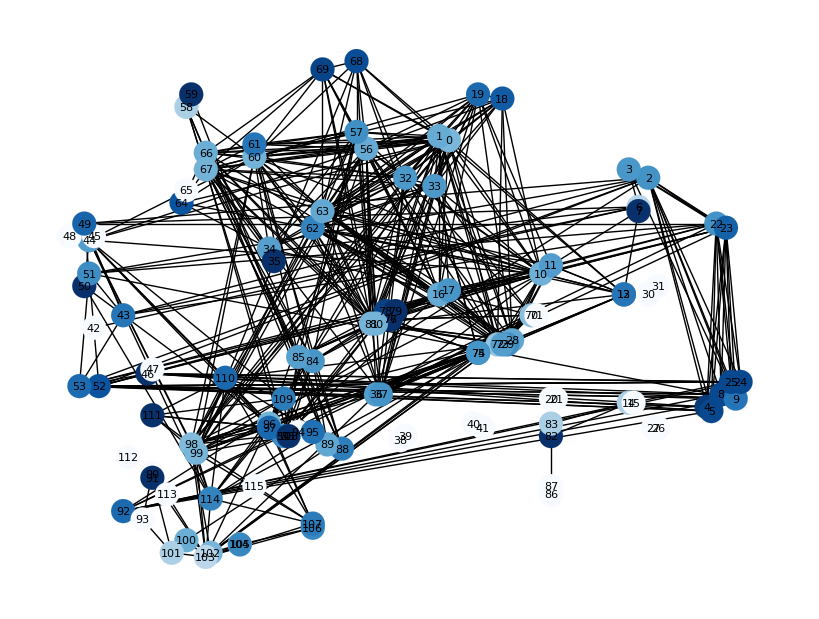

In [19]:
C = nx.clustering(G)

# plt.figure(figsize=(8,6))
# plt.title('Con nodos en sus coordenadas cerebrales', fontsize=14)
layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
# hacer nx.draw con el color de cada nodo según "clustering"
nx.draw(G, pos=layout, node_color=list(C.values()), with_labels=True,
        node_size=300, cmap=plt.cm.Blues,
        linewidths=.1, font_size=8)
plt.savefig('proyecto_latex/imagenes/2_Sujeto2W.png')

11. Graﬁcar la distribución de grado del grafo, elijiendo un número de bins apropriado.

C:\Users\joses\AppData\Local\Temp\ipykernel_17076\1330647399.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([G.degree(n) for n in G.nodes()], bins=20, color=plt.cm.Blues(.5),kde=False)


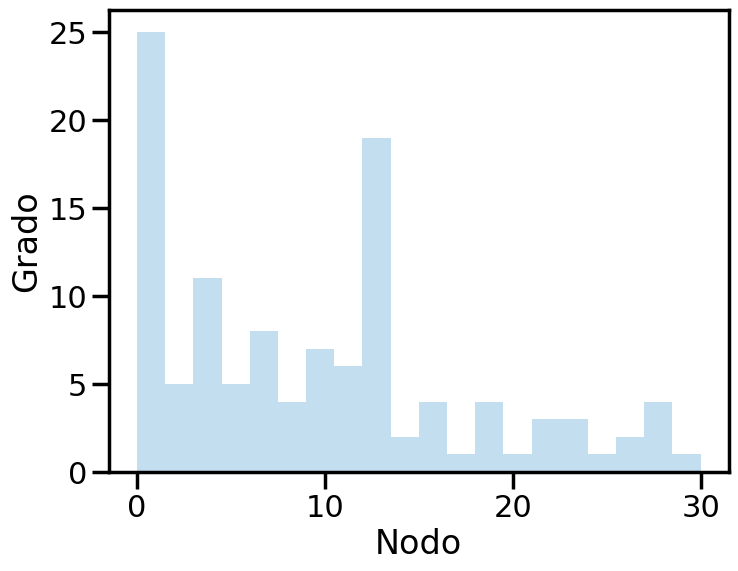

In [128]:
# Graﬁcar la distribución de grado del grafo, elijiendo un número de bins apropriado
# hacer un histograma con el grado de cada nodo
# plotear lo mismo en seaborn
sns.distplot([G.degree(n) for n in G.nodes()], bins=20, color=plt.cm.Blues(.5),kde=False)
plt.xlabel('Nodo', fontsize=24)
plt.ylabel('Grado', fontsize=24)
plt.savefig('proyecto_latex/imagenes/3_Sujeto2W.png');

C:\Users\joses\AppData\Local\Temp\ipykernel_17076\1359485513.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([G.degree(n) for n in G.nodes()], bins=20, color=plt.cm.Blues(.5),kde=False,ax=ax[1])


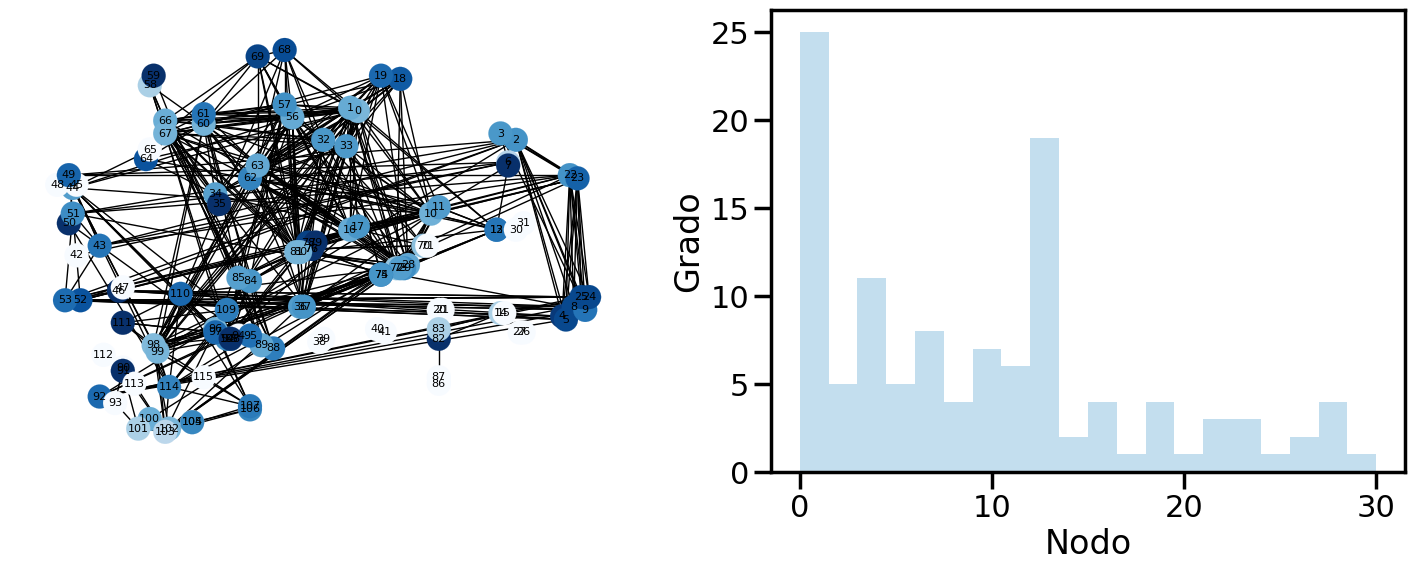

In [133]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

C = nx.clustering(G)

# plt.figure(figsize=(8,6))
# plt.title('Con nodos en sus coordenadas cerebrales', fontsize=14)
layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
# hacer nx.draw con el color de cada nodo según "clustering"
nx.draw(G, pos=layout, node_color=list(C.values()), with_labels=True,
        node_size=300, cmap=plt.cm.Blues,
        linewidths=.1, font_size=8,ax=ax[0])

# Graﬁcar la distribución de grado del grafo, elijiendo un número de bins apropriado
# hacer un histograma con el grado de cada nodo
# plotear lo mismo en seaborn
sns.distplot([G.degree(n) for n in G.nodes()], bins=20, color=plt.cm.Blues(.5),kde=False,ax=ax[1])
plt.xlabel('Nodo', fontsize=24)
plt.ylabel('Grado', fontsize=24)
plt.savefig('proyecto_latex/imagenes/grafo_hist.png');

Vamos a comparar el grafo G con prototipos de redes poissonianas (random), small-World y scale-free, usando los algoritmos de Erdos-Renyi, Watts-Strogatz y Barabasi-Albert, respectivamente. Para ello, elegir (y reportar) los parámetros utilizados para cada algoritmo, buscando siempre que los grafos simulados de dichos prototipos sean comparables al grafo de datos G (en términos de número de nodos y números de enlaces). Visualizar un ejemplo de grafo para cada uno de estos prototipos de redes. Discutir diferencias.

In [21]:
# obtener numero de enlaces de G
L = len(G.edges())
print(L)

534


In [22]:
# # obtener red poissioniana con el mismo numero de nodos y enlaces
# G_poisson = nx.erdos_renyi_graph(n,L/(n*(n-1)),seed=42)
# # obtener red small world con el mismo numero de nodos y enlaces
# G_small_world = nx.watts_strogatz_graph(n,round(K),0.1,seed=42)
# # obteenr red libre de escala con el mismo numero de nodos y enlaces
# G_scale_free = nx.barabasi_albert_graph(n,round(K/2),seed=42)

In [14]:
grado_medio = 2*G.number_of_edges()/G.number_of_nodes()

In [35]:
G.number_of_edges()

534

In [15]:
# obtener red poissioniana con el mismo numero de nodos y enlaces
G_poisson = nx.gnm_random_graph(G.number_of_nodes(),G.number_of_edges(),seed=42)
# obtener red small world con el mismo numero de nodos y enlaces
G_small_world = nx.watts_strogatz_graph(G.number_of_nodes(),int(grado_medio),0.02,seed=42)
# obteenr red libre de escala con el mismo numero de nodos y enlaces
G_scale_free = nx.barabasi_albert_graph(G.number_of_nodes(),int(grado_medio/1.75),seed=42)

In [16]:
REDES = ['Poisson','Small world','Libre de escala']
NODOS = [G_poisson.number_of_nodes(),G_small_world.number_of_nodes(),G_scale_free.number_of_nodes()]
ENLACES = [G_poisson.number_of_edges(),G_small_world.number_of_edges(),G_scale_free.number_of_edges()]
PAR_2 = ['-','Vecinos conectados a cada nodo','Q de enlaces nuevos por nodo nuevo']
valor_PAR_2 = ['-',int(grado_medio),int(grado_medio/1.75)]
PAR_3 = ['-','Prob. de re-conexión','-']

tabla = pd.DataFrame({'Red':REDES,
                      'Nodos':NODOS,
                      'Enlaces':ENLACES,
                      'Parámetro 2 (scale free y small world)':PAR_2,
                      '.':valor_PAR_2,
                      'Parámetro 3 (small world)':PAR_3,
                      '':['-',0.02,'-']})
print(tabla.to_latex(index=False,caption='Parámetros de las redes aleatorias'))

\begin{table}
\caption{Parámetros de las redes aleatorias}
\begin{tabular}{lrrllll}
\toprule
Red & Nodos & Enlaces & Parámetro 2 (scale free y small world) & . & Parámetro 3 (small world) &  \\
\midrule
Poisson & 116 & 534 & - & - & - & - \\
Small world & 116 & 464 & Vecinos conectados a cada nodo & 9 & Prob. de re-conexión & 0.020000 \\
Libre de escala & 116 & 555 & Q de enlaces nuevos por nodo nuevo & 5 & - & - \\
\bottomrule
\end{tabular}
\end{table}



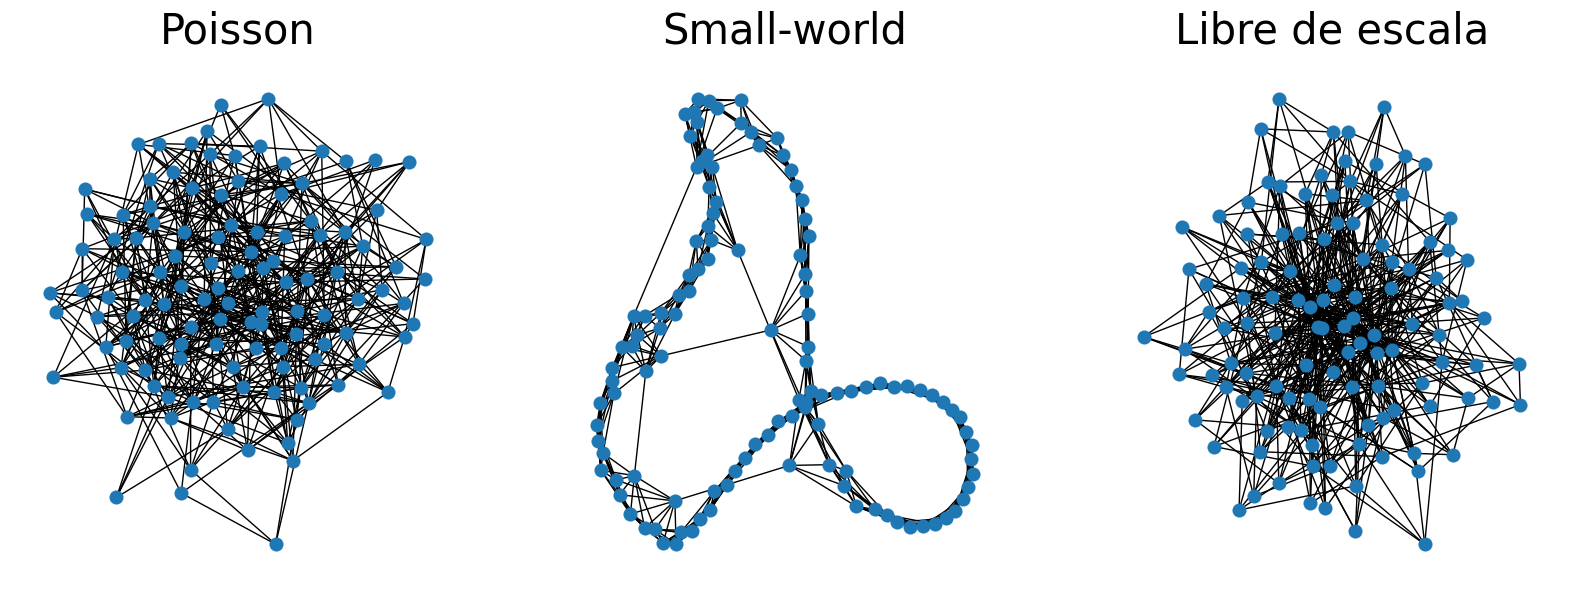

In [19]:
#graficar los tres grafos en una misma figura
plt.figure(figsize=(20,7))
plt.subplot(131)
plt.title('Poisson', fontsize=30)
# hacer nx.draw con el color de cada nodo según "clustering"
nx.draw(G_poisson, 
        pos=nx.fruchterman_reingold_layout(G_poisson), 
        # node_color=list(C.values()), 
        # with_labels=True,
        node_size=100, 
        cmap=plt.cm.Blues,
        linewidths=.1, font_size=8)
plt.subplot(132)
plt.title('Small-world', fontsize=30)
# hacer nx.draw con el color de cada nodo según "clustering"
nx.draw(G_small_world, 
        pos=nx.fruchterman_reingold_layout(G_small_world),
        # node_color=list(C.values()),
        # with_labels=True,
        node_size=100, 
        cmap=plt.cm.Blues,
        linewidths=.1, font_size=8)
plt.subplot(133)
plt.title('Libre de escala', fontsize=30)
# hacer nx.draw con el color de cada nodo según "clustering"
nx.draw(G_scale_free,
        pos=nx.fruchterman_reingold_layout(G_scale_free), 
        # node_color=list(C.values()), 
        # with_labels=True,
        node_size=100, 
        cmap=plt.cm.Blues,
        linewidths=.1, font_size=8)
plt.savefig('proyecto_latex/imagenes/4_Sujeto2W.png');

Generar 1000 instancias de grafos para cada uno de dichos prototipos (poissonianas, small-World y scale-free). Para el conjunto de 1000 instancias de cada prototipo, calcular el histograma de coeﬁcientes de < k >, kmax, C, y ef f . Comparar con los valores de coeﬁcientes que obtuvimos para el grafo de datos G

In [111]:
# generar 1000 instancias de grafos para cada tipo de red
n_graphs = 1000
G_poisson = [nx.gnm_random_graph(G.number_of_nodes(),G.number_of_edges()) for i in range(n_graphs)]
G_small_world = [nx.watts_strogatz_graph(G.number_of_nodes(),int(grado_medio),0.02) for i in range(n_graphs)]
G_scale_free = [nx.barabasi_albert_graph(G.number_of_nodes(),int(grado_medio/1.75)) for i in range(n_graphs)]

#para el conjunto de 1000 instancias de cada red, calcular el histograma de coefiicentes de k, kmax, C
C_poisson = [nx.average_clustering(G) for G in G_poisson]
C_small_world = [nx.average_clustering(G) for G in G_small_world]
C_scale_free = [nx.average_clustering(G) for G in G_scale_free]

K_poisson = []
for G in G_poisson:
    K_poisson.append(np.mean([G.degree(n) for n in G.nodes()]))
    
K_small_world = []
for G in G_small_world:
    K_small_world.append(np.mean([G.degree(n) for n in G.nodes()]))

K_scale_free = []
for G in G_scale_free:
    K_scale_free.append(np.mean([G.degree(n) for n in G.nodes()]))

kmax_poisson = [np.max([G.degree(n) for n in G.nodes()]) for G in G_poisson]
kmax_small_world = [np.max([G.degree(n) for n in G.nodes()]) for G in G_small_world]
kmax_scale_free = [np.max([G.degree(n) for n in G.nodes()]) for G in G_scale_free]

# calcular eficiencia global para las tres redes
E_poisson = [nx.global_efficiency(G) for G in G_poisson]
E_small_world = [nx.global_efficiency(G) for G in G_small_world]
E_scale_free = [nx.global_efficiency(G) for G in G_scale_free]

In [118]:
G = nx.from_numpy_array(matAdyacNoPesada)
#calcular la eficiencia global del grafo G
eficiencia = nx.global_efficiency(G)

# calcular el grado promedio "K" del nodo G
K = np.mean([G.degree(n) for n in G.nodes()])

# calcular el nodo de mayor grado "kmax" del grafo G
kmax = np.max([G.degree(n) for n in G.nodes()])

#calcular el coeficiente de clustering promedio "C" del grafo G
C = nx.average_clustering(G)

pd.DataFrame({'Grado promedio (K)':[K],'Nodo con grado máximo (kmax)':[kmax],'Coeficiente de clustering promedio (C)':[C],'Eficiencia':eficiencia}).T

,0
Grado promedio (K),9.206897
Nodo con grado máximo (kmax),30.000000
Coeficiente de clustering promedio (C),0.527085
Eficiencia,0.244630


In [116]:
# armar dataeframe con las metricas da cada red
df_poisson = pd.DataFrame({'red':'Poisson','K':K_poisson,'kmax':kmax_poisson,'C':C_poisson,'Eficiencia':E_poisson})
df_small_world = pd.DataFrame({'red':'Small world','K':K_small_world,'kmax':kmax_small_world,'C':C_small_world,'Eficiencia':E_small_world})
df_scale_free = pd.DataFrame({'red':'Libre de Escala','K':K_scale_free,'kmax':kmax_scale_free,'C':C_scale_free,'Eficiencia':E_scale_free})

coeficientes = pd.concat((df_poisson,df_small_world,df_scale_free),axis=0)
coeficientes

,red,K,kmax,C,Eficiencia
0,Poisson,9.206897,18,0.082510,0.465980
1,Poisson,9.206897,16,0.079070,0.465642
2,Poisson,9.206897,18,0.083705,0.467666
3,Poisson,9.206897,18,0.085159,0.465280
4,Poisson,9.206897,18,0.080475,0.464130
...,...,...,...,...,...
995,Libre de Escala,9.568966,43,0.172977,0.480747
996,Libre de Escala,9.568966,35,0.175183,0.481422
997,Libre de Escala,9.568966,35,0.170726,0.479385
998,Libre de Escala,9.568966,50,0.179538,0.481959


In [ ]:
np.mean()

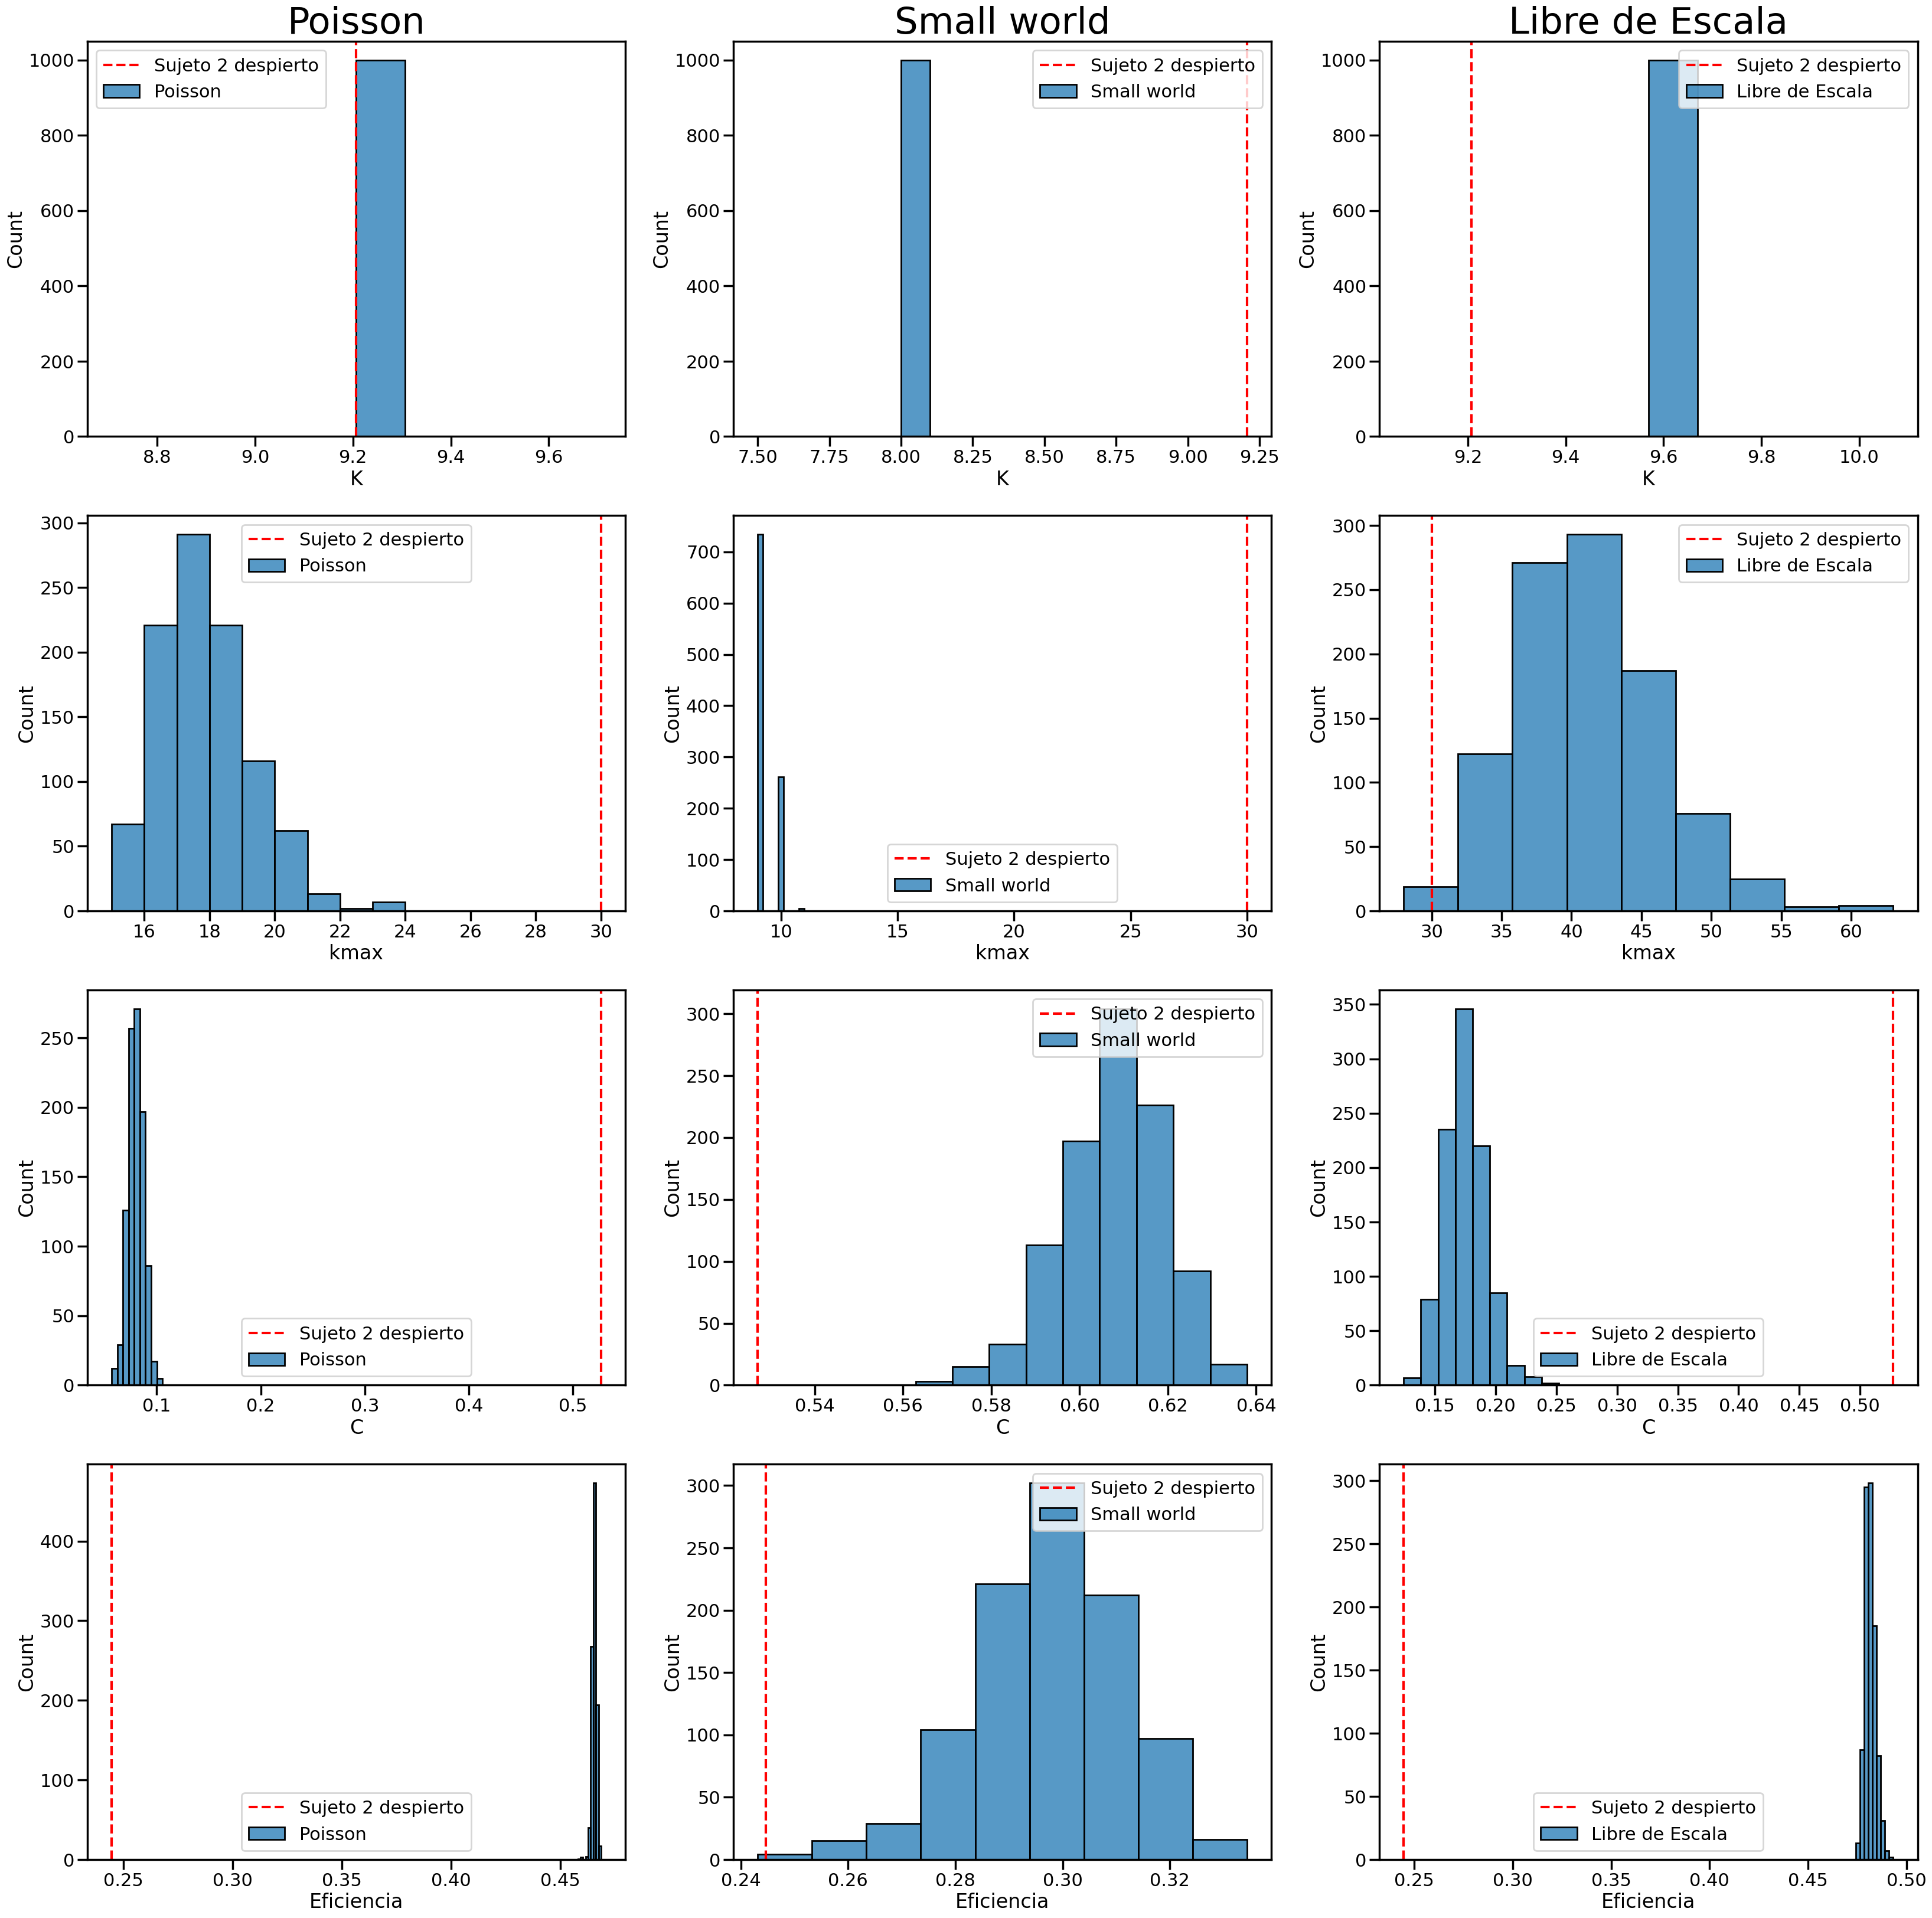

In [117]:
# calcular el grado promedio "K" del nodo G
K = np.mean([G.degree(n) for n in G.nodes()])

# calcular el nodo de mayor grado "kmax" del grafo G
kmax = np.max([G.degree(n) for n in G.nodes()])

#calcular el coeficiente de clustering promedio "C" del grafo G
C = nx.average_clustering(G)

eficiencia_g = nx.global_efficiency(G)

metricas_g_default = pd.DataFrame({'K':[K],'kmax':[kmax],'C':[C],'Eficiencia':[eficiencia_g]})

coeficientes

#graficar histograms de cada coeficiente de cada red en un gráfico de 3X4 con seaborn
fig, ax = plt.subplots(4,3,figsize=(40,40))
for row,metrica in enumerate(['K','kmax','C','Eficiencia']):
    for column,red in enumerate(['Poisson','Small world','Libre de Escala']):
        # ajustar cantidad de bins para que se vea bien
        if metrica!='K':
            bins = np.linspace(coeficientes[coeficientes['red']==red][metrica].min(),coeficientes[coeficientes['red']==red][metrica].max(),10)
            sns.histplot(coeficientes[coeficientes['red']==red][metrica],ax=ax[row,column],bins=bins)
        else:
            sns.histplot(coeficientes[coeficientes['red']==red][metrica],ax=ax[row,column],bins=10)
        # agregar una linea vertical con el valor de metricas_g_default
        ax[row,column].axvline(metricas_g_default[metrica].values[0],color='r',linestyle='--')
        # add line label
        ax[row,column].legend(['Sujeto 2 despierto',red])
        if row==0:
            ax[row,column].set_title(red,size=45)
plt.savefig('proyecto_latex/imagenes/5_Sujeto2W.png');